In [2]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense
from keras.optimizers import SGD

%matplotlib inline

In [3]:
train_dir = 'data/train-preprocess'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train-preprocess 0
data/train-preprocess/MEL 1113
data/train-preprocess/DF 115
data/train-preprocess/BKL 1099
data/train-preprocess/BCC 514
data/train-preprocess/VASC 142
data/train-preprocess/AKIEC 327
data/train-preprocess/NV 6705


In [5]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.25)

# target_size = (height, width)
target_size = (450, 600)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        batch_size=32,
        subset="training",
        shuffle = True)

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        batch_size=32,
        subset = "validation",
        shuffle = True)

Found 7515 images belonging to 7 classes.
Found 2500 images belonging to 7 classes.


In [6]:
output_classes = 7

batch_size = 32 
epochs = 30
learning_rate= 0.001
# input_shape=(img_height, img_width, img_ckannels),
input_shape = (450,600,3)

# optimizer = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
optimizer = 'adam'

In [7]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(output_classes, activation='softmax'))

In [8]:
model.layers[0].trainable = False
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = 400,
      epochs = epochs,
      verbose = 1,      
      validation_data = validation_generator,
      validation_steps = 100)

Epoch 1/30
400/400 [==============================] - 12549s 31s/step - loss: 0.8901 - acc: 0.6917 - val_loss: 3.1621 - val_acc: 0.6704
Epoch 2/30
400/400 [==============================] - 12524s 31s/step - loss: 0.7485 - acc: 0.7285 - val_loss: 3.2434 - val_acc: 0.6704
Epoch 3/30
400/400 [==============================] - 12530s 31s/step - loss: 0.7203 - acc: 0.7379 - val_loss: 3.1653 - val_acc: 0.6704
Epoch 4/30
400/400 [==============================] - 12528s 31s/step - loss: 0.6853 - acc: 0.7477 - val_loss: 3.1709 - val_acc: 0.6704
Epoch 5/30
400/400 [==============================] - 12535s 31s/step - loss: 0.6644 - acc: 0.7508 - val_loss: 3.4239 - val_acc: 0.6704
Epoch 6/30
400/400 [==============================] - 12533s 31s/step - loss: 0.6349 - acc: 0.7642 - val_loss: 3.0378 - val_acc: 0.6704
Epoch 7/30
400/400 [==============================] - 12536s 31s/step - loss: 0.6298 - acc: 0.7698 - val_loss: 3.6697 - val_acc: 0.6704
Epoch 8/30
400/400 [============================

In [10]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  5.203288269042969
Test Accuracy:  0.013125


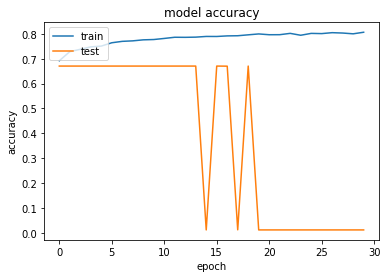

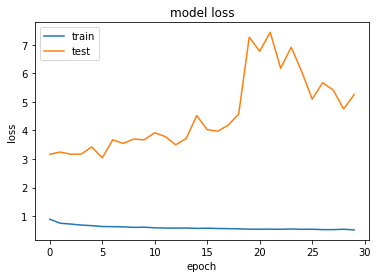

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [13]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

79/78 [==============================] - 2652s 34s/step
No of errors = 2472/2500


/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Confusion matrix, without normalization
[[   0    0    0   81    0    0    0]
 [   0    0    0  128    0    0    0]
 [   0    0    0  274    0    0    0]
 [   0    0    0   28    0    0    0]
 [   0    0    0  278    0    0    0]
 [   0    0    0 1676    0    0    0]
 [   0    0    0   35    0    0    0]]


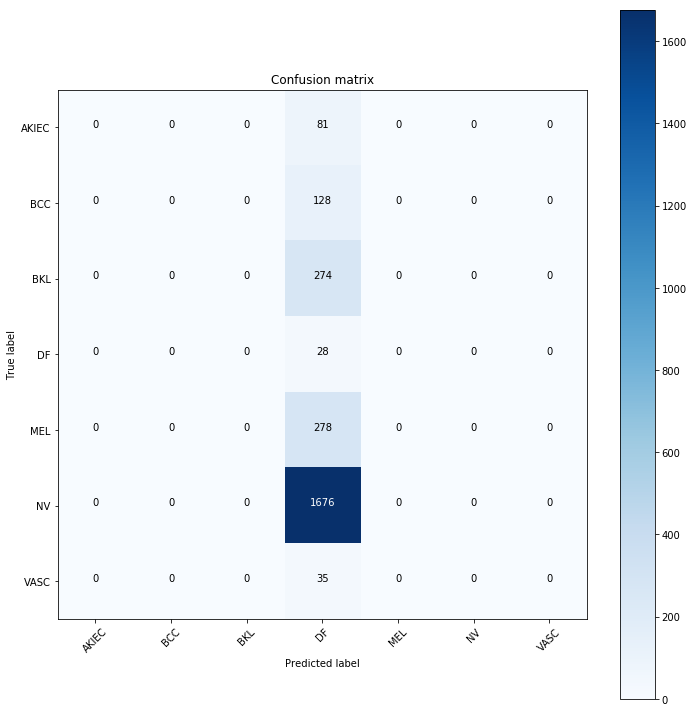

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix')

In [15]:
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))

In [ ]:
predict_and_report(train_generator, model)
predict_and_report(validation_generator, model)

In [ ]:
best_train_acc = max(history.history['acc'])
best_train_acc

In [ ]:
last_train_acc = history.history['acc'][-1]
last_train_acc

In [ ]:
results.append([train_dir, optimizer,learning_rate, batch_size, epochs, last_train_acc, best_train_acc, score[0], score[1]])

In [ ]:
import  pandas  as  pd
res = pd.DataFrame(results)
res.columns = ['data', 'optimizer','learning_rate','batch_size', 'epochs','last_train_accuracy', 'best_training_accuracy','test Score', 'test_accuracy']
res

In [ ]:
res.to_csv("ResNet-With.csv", sep=',', encoding='utf-8')